# Assignment 1 2AMM10 2023-2024

## Group: [Fill in your group name]
### Member 1: [Fill in your name]
### Member 2: [Fill in your name]
### Member 3: [Fill in your name]

In [1]:
import os
import pandas as pd
import torch 
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from torchvision import transforms
import kagglehub
import torchvision.transforms as transforms

# add additonal imports here
class FashionDataset(Dataset):
    def __init__(self, csv_file, img_dir,column_class="articleTypeId", transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file with labels.
            img_dir (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.df = pd.read_csv(csv_file)  # load CSV file
        self.img_dir = img_dir  # image folder path
        self.transform = transform  # image transformations
        self.targets = list(self.df[column_class].values)


    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, f"{self.df.loc[idx,'imageId']}.jpg")  # Get image filename
        image = Image.open(img_name).convert("RGB")  # Load image

        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, self.targets[idx]

Download data with kagglehub

In [2]:
# import shutil
# import os

dataset_path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")
img_dir = os.path.join(dataset_path,"images")

# shutil.rmtree(dataset_path)

The different datasets can be loaded using the class `FashionDataset` which is a custon PyTorch dataset (see [Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) for more information). Below an example of how to use the `FashionDataset` constructor as well as some visualizations. Please note that you may have to adapt the arguments to match the strucucture of your working directory.

In [3]:
dataset = FashionDataset("dataset/train.csv",img_dir)

In [4]:
dataset.df.head()

,imageId,articleTypeName,categoryName,articleTypeId,categoryId
0,35180,Backpacks,Bags,15,2
1,33585,Tshirts,Topwear,0,0
2,9464,Shirts,Topwear,1,0
3,8194,Shirts,Topwear,1,0
4,42231,Tops,Topwear,6,0


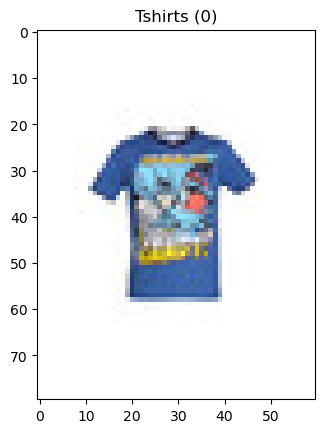

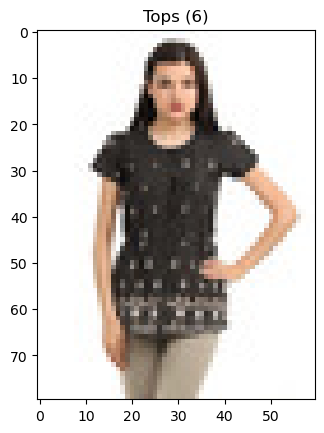

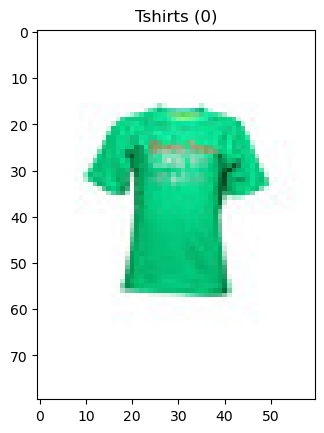

In [5]:
np.random.seed(42)
random_indices = np.random.choice(len(dataset),3)

for i in random_indices:
    img, label = dataset[i]
    plt.title(dataset.df.iloc[i]["articleTypeName"]+f" ({label.item()})")
    plt.imshow(img)
    plt.show()

## Loading different datasets

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# transform = transforms.Compose([
#     transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(degrees=15),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])

train_dataset = FashionDataset("dataset/train.csv",img_dir,transform=transform)
main_test_dataset =  FashionDataset("dataset/main_test.csv",img_dir,transform=transform)
new_test_dataset =  FashionDataset("dataset/new_test.csv",img_dir,transform=transform)
main_support_dataset =  FashionDataset("dataset/main_support.csv",img_dir,transform=transform)
new_support_dataset =  FashionDataset("dataset/new_support.csv",img_dir,transform=transform)
merged_test_dataset =  FashionDataset("dataset/merged_test.csv",img_dir,transform=transform) # merged corresponds to main+new
merged_support_dataset =  FashionDataset("dataset/merged_support.csv",img_dir,transform=transform)

# datasets with categories
main_test_dataset_cat =  FashionDataset("dataset/main_test.csv",img_dir,column_class="categoryId",transform=transform)
main_support_dataset_cat =  FashionDataset("dataset/main_support.csv",img_dir,column_class="categoryId",transform=transform)


label_id_to_label_name = {i: train_dataset.df[train_dataset.df["articleTypeId"]==i]["articleTypeName"].iloc[0] for i in range(39)} 
label_id_to_label_name.update({i: new_test_dataset.df[new_test_dataset.df["articleTypeId"]==i]["articleTypeName"].iloc[0] for i in range(39,39+30)})

## Task 1

In [7]:
# your solution
# train dataset: train_dataset
# test datset: main_test_dataset

In [7]:
# define network archietecture

class FashionNet(torch.nn.Module):
    def __init__(self, num_classes):
        super(FashionNet, self).__init__()

        # convolutional layers
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size = 3, padding = 1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size = 3, padding = 1)

        # batch normalization layers
        self.bn1 = torch.nn.BatchNorm2d(32)
        self.bn2 = torch.nn.BatchNorm2d(64)
        self.bn3 = torch.nn.BatchNorm2d(128)

        # pooling layer
        self.pool = torch.nn.MaxPool2d(2, 2)

        # dropout layer
        self.dropout = torch.nn.Dropout(0.25)

        # fully conneted layer
        self.fc1 = torch.nn.Linear(128 * 28 * 28, 512)
        # self.fc1 = torch.nn.Linear(256 * 14 * 14, 512)
        self.fc2 = torch.nn.Linear(512, num_classes)

        # activation function
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        # First convolutional block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Second convolutional block
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Third convolutional block
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)
        
        # Fully connected layers with dropout
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x # already without softmax => can be used as a feature



Training

In [ ]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.amp import autocast, GradScaler

# hyperparameters
batch_size = 32
num_epochs = 10
learning_rate = 1e-4
weight_decay = 1e-4

# create data loader
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(main_test_dataset, batch_size = batch_size, shuffle = False)

num_classes = len(train_dataset.df['articleTypeId'].unique())

# initialize the model
model = FashionNet(num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Improved training function with AMP
def train_model(model, train_loader, test_loader, device, epochs=30):
    model = model.to(device)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)

    # Initialize gradient scaler for AMP
    scaler = GradScaler()
    
    # Track best model
    best_test_acc = 0.0
    
    print(f"Starting training for {epochs} epochs...")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        
        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            
            # Use AMP autocast
            with autocast(device_type='cuda', enabled=torch.cuda.is_available()):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            # Scale gradients and perform backward pass
            scaler.scale(loss).backward()
            
            # Update weights with scaled gradients
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
            
            train_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{(train_correct/train_total):.4f}'
            })
        
        train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total
        
        # Test phase
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        
        test_pbar = tqdm(test_loader, desc=f'Epoch {epoch+1}/{epochs} [Test]')
        
        with torch.no_grad():
            for inputs, labels in test_pbar:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                test_total += labels.size(0)
                test_correct += predicted.eq(labels).sum().item()
                
                test_pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{(test_correct/test_total):.4f}'
                })
        
        test_loss = test_loss / len(test_loader)
        test_acc = test_correct / test_total
        
        # Update learning rate based on test accuracy
        scheduler.step(test_acc)
        
        # Print results
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

        # Clean GPU cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        # Save best model
        if test_acc > best_test_acc: 
            best_test_acc = test_acc
            # Save the model if needed
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"New best test accuracy: {test_acc:.4f}")

    print(f"Training completed! Best test accuracy: {best_test_acc:.4f}")
    return model

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
print(f"Using device: {device}")
model = train_model(model, train_loader, test_loader, device, 10)

In [ ]:
from sklearn.metrics import balanced_accuracy_score
def evaluate_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # No need to track gradients
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Regular accuracy
    accuracy = 100 * correct / total
    # Balanced accuracy
    balanced_acc = 100 * balanced_accuracy_score(all_labels, all_preds)
    
    return accuracy, balanced_acc

# After training your model
acc, bal_acc = evaluate_model(model, test_loader, device)
print(f'Accuracy: {acc:.2f}%')
print(f'Balanced Accuracy: {bal_acc:.2f}%')

## Task 2

In [ ]:
# your solution
# train dataset: train_dataset
# test and support dataset: see scenarios table

In [ ]:
# triplet dataset

In [8]:
from torch.utils.data import Dataset
import random

class TripletDataset(Dataset):
    def __init__(self, image_dataset):  # image_dataset = torchvision.datasets.ImageFolder or custom
        self.image_dataset = image_dataset
        self.labels = image_dataset.targets
        self.class_to_indices = self._map_labels_to_indices()

    def _map_labels_to_indices(self):
        from collections import defaultdict
        mapping = defaultdict(list)
        for idx, label in enumerate(self.labels):
            mapping[label].append(idx)
        return mapping

    def __getitem__(self, idx):
        anchor_img, anchor_label = self.image_dataset[idx]

        # Positive
        pos_idx = random.choice(self.class_to_indices[anchor_label])
        pos_img, _ = self.image_dataset[pos_idx]

        # Negative
        neg_label = random.choice([l for l in self.class_to_indices if l != anchor_label])
        neg_idx = random.choice(self.class_to_indices[neg_label])
        neg_img, _ = self.image_dataset[neg_idx]

        return anchor_img, pos_img, neg_img

    def __len__(self):
        return len(self.image_dataset)


In [9]:
# new training

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.amp import autocast, GradScaler

def train_embedding_model(model, triplet_loader, device, epochs=20, margin=1.0):
    model = model.to(device)
    criterion = nn.TripletMarginLoss(margin=margin)
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scaler = GradScaler()

    print(f"Starting embedding training for {epochs} epochs...")

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        pbar = tqdm(triplet_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for anchor, positive, negative in pbar:
            anchor, positive, negative = (
                anchor.to(device),
                positive.to(device),
                negative.to(device),
            )

            optimizer.zero_grad()

            with autocast(device_type='cuda', enabled=torch.cuda.is_available()):
                anchor_feat = model(anchor)
                positive_feat = model(positive)
                negative_feat = model(negative)

                loss = criterion(anchor_feat, positive_feat, negative_feat)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            pbar.set_postfix({"triplet_loss": f"{loss.item():.4f}"})

        avg_loss = running_loss / len(triplet_loader)
        print(f"Epoch {epoch+1}: Avg Triplet Loss = {avg_loss:.4f}")

        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    print("Training complete.")
    return model

In [19]:
# train model

In [11]:
from torch.utils.data import DataLoader

triplet_dataset = TripletDataset(train_dataset)
triplet_loader = DataLoader(triplet_dataset, batch_size=32, shuffle=True)

In [12]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("CUDA version:", torch.version.cuda)

PyTorch version: 2.5.1+cu121
CUDA available: True
Number of GPUs: 1
GPU Name: NVIDIA GeForce RTX 4070 Laptop GPU
CUDA version: 12.1


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [80]:
model = FashionNet(num_classes=256)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model = train_embedding_model(model, triplet_loader, device, epochs=10)

Starting embedding training for 10 epochs...


Epoch 1/10: 100%|█████████████████████████████████████████████| 1123/1123 [18:26<00:00,  1.02it/s, triplet_loss=0.5863]


Epoch 1: Avg Triplet Loss = 0.4087


Epoch 2/10: 100%|█████████████████████████████████████████████| 1123/1123 [18:26<00:00,  1.01it/s, triplet_loss=0.0000]


Epoch 2: Avg Triplet Loss = 0.2434


Epoch 3/10: 100%|█████████████████████████████████████████████| 1123/1123 [17:39<00:00,  1.06it/s, triplet_loss=0.0000]


Epoch 3: Avg Triplet Loss = 0.1673


Epoch 4/10: 100%|█████████████████████████████████████████████| 1123/1123 [38:48<00:00,  2.07s/it, triplet_loss=0.0112]


Epoch 4: Avg Triplet Loss = 0.1292


Epoch 5/10: 100%|█████████████████████████████████████████████| 1123/1123 [18:01<00:00,  1.04it/s, triplet_loss=0.0000]


Epoch 5: Avg Triplet Loss = 0.1106


Epoch 6/10: 100%|█████████████████████████████████████████████| 1123/1123 [17:53<00:00,  1.05it/s, triplet_loss=0.4101]


Epoch 6: Avg Triplet Loss = 0.0985


Epoch 7/10: 100%|█████████████████████████████████████████████| 1123/1123 [18:03<00:00,  1.04it/s, triplet_loss=0.0000]


Epoch 7: Avg Triplet Loss = 0.1044


Epoch 8/10: 100%|█████████████████████████████████████████████| 1123/1123 [18:12<00:00,  1.03it/s, triplet_loss=0.3290]


Epoch 8: Avg Triplet Loss = 0.0833


Epoch 9/10: 100%|█████████████████████████████████████████████| 1123/1123 [18:08<00:00,  1.03it/s, triplet_loss=0.0000]


Epoch 9: Avg Triplet Loss = 0.0682


Epoch 10/10: 100%|████████████████████████████████████████████| 1123/1123 [17:59<00:00,  1.04it/s, triplet_loss=0.0685]

Epoch 10: Avg Triplet Loss = 0.0650
Training complete.


In [ ]:
# save model

In [81]:
torch.save(model.state_dict(), "trained_triplet_model_v20250525.pth")

In [ ]:
# load model

In [15]:
model = FashionNet(num_classes=256)
model.load_state_dict(torch.load("trained_triplet_model_v20250525.pth", weights_only=True))
model.to(device)
model.eval()

FashionNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (relu): ReLU()
)

In [16]:
# extract feature

In [17]:
def extract_features(model, dataloader, device):
    model.eval()
    features, labels = [], []

    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Extracting features"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu())
            labels.extend(targets.cpu().tolist())

    return torch.cat(features), labels

In [18]:
# neighbor classify

In [19]:
import torch.nn.functional as F

def classify_by_nearest_neighbor(test_features, support_features, support_labels, metric='cosine'):
    predictions = []

    for test_feat in test_features:
        if metric == 'cosine':
            sims = F.cosine_similarity(test_feat.unsqueeze(0), support_features)
            idx = torch.argmax(sims).item()
        if metric == 'euclidean':
            dists = torch.norm(support_features - test_feat.unsqueeze(0), dim=1)
            idx = torch.argmin(dists).item()

        predictions.append(support_labels[idx])
    
    return predictions

In [20]:
# method to evaluate

In [21]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

def evaluate_predictions(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc * 100:.2f}%")
    print(f"Balanced Accuracy: {bal_acc * 100:.2f}%")
    return acc, bal_acc

In [87]:
# Scenario 1

In [88]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
main_test_loader = DataLoader(main_test_dataset, batch_size=32, shuffle=False)

support_features, support_labels = extract_features(model, train_loader, device)
test_features, test_labels = extract_features(model, main_test_loader, device)

preds = classify_by_nearest_neighbor(test_features, support_features, support_labels)
evaluate_predictions(test_labels, preds)

Extracting features: 100%|█████████████████████████████████████████████████████████████| 63/63 [00:25<00:00,  2.52it/s]


Accuracy: 77.77%
Balanced Accuracy: 71.89%


(0.7776664997496244, np.float64(0.7188685033134404))

In [89]:
# Scenario 2

In [90]:
main_support_loader = DataLoader(main_support_dataset, batch_size=32, shuffle=False)

support_features, support_labels = extract_features(model, main_support_loader, device)
test_features, test_labels = extract_features(model, main_test_loader, device)

preds = classify_by_nearest_neighbor(test_features, support_features, support_labels)
evaluate_predictions(test_labels, preds)

Extracting features: 100%|█████████████████████████████████████████████████████████████| 63/63 [00:21<00:00,  2.92it/s]


Accuracy: 69.20%
Balanced Accuracy: 62.88%


(0.6920380570856285, np.float64(0.6287910379194245))

In [91]:
# Scenario 3

In [92]:
new_support_loader = DataLoader(new_support_dataset, batch_size=32, shuffle=False)
new_test_loader = DataLoader(new_test_dataset, batch_size=32, shuffle=False)

support_features, support_labels = extract_features(model, new_support_loader, device)
test_features, test_labels = extract_features(model, new_test_loader, device)

preds = classify_by_nearest_neighbor(test_features, support_features, support_labels)
evaluate_predictions(test_labels, preds)

Extracting features: 100%|█████████████████████████████████████████████████████████████| 52/52 [00:18<00:00,  2.79it/s]


Accuracy: 71.63%
Balanced Accuracy: 70.69%


(0.7162650602409638, np.float64(0.7069325403853564))

In [93]:
# Scenario 4

In [94]:
merged_support_loader = DataLoader(merged_support_dataset, batch_size=32, shuffle=False)
merged_test_loader = DataLoader(merged_test_dataset, batch_size=32, shuffle=False)

support_features, support_labels = extract_features(model, merged_support_loader, device)
test_features, test_labels = extract_features(model, merged_test_loader, device)

preds = classify_by_nearest_neighbor(test_features, support_features, support_labels)
evaluate_predictions(test_labels, preds)

Extracting features: 100%|███████████████████████████████████████████████████████████| 115/115 [00:32<00:00,  3.52it/s]


Accuracy: 63.06%
Balanced Accuracy: 58.18%


(0.6305715066994805, np.float64(0.5817809431991416))

## Task 3

In [45]:
# your solution
# test dataset: merged_test_dataset
# support/catalog dataset: support_test_dataset

In [46]:
# install what is needed

In [47]:
#!pip install matplotlib scikit-learn tqdm

In [48]:
# import what is needed

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

%matplotlib inline
plt.style.use('ggplot')

In [23]:
# methods to compute top-k and confidence values

In [24]:
def get_top_k_similarities(test_feature, support_features, k=3):
    if test_feature.ndim != 1:
        test_feature = test_feature.reshape(-1)
    similarities = cosine_similarity([test_feature], support_features)[0]
    top_k_indices = np.argsort(similarities)[-k:][::-1]
    return top_k_indices, similarities[top_k_indices]

def compute_confidence(similarities):
    return similarities[0] - similarities[2]

In [25]:
# plot func

In [26]:
def plot(error_rates,coverage_rates):
    plt.figure(figsize=(8, 6))
    plt.plot(error_rates, coverage_rates, marker='o', color='orange')
    plt.xlabel('Error Rate (%)')
    plt.ylabel('Coverage (%)')
    plt.title('Error Rate vs. Coverage')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [27]:
# evaluate recommendation

In [33]:
def evaluate_recommendation_raw_way(support_features,support_labels,test_features,test_labels):
    thresholds = np.linspace(0, 1, 50)
    error_rates = []
    coverage_rates = []
    
    for threshold in tqdm(thresholds):
        total = len(test_features)
        shown = 0
        incorrect = 0
    
        for i, test_feature in enumerate(test_features):
            top_k_indices, similarities = get_top_k_similarities(test_feature, support_features)
            confidence = compute_confidence(similarities)
    
            if confidence >= threshold:
                shown += 1
                recommended_labels = support_labels[top_k_indices]
                if test_labels[i] not in recommended_labels:
                    incorrect += 1
    
        coverage = shown / total if total else 0
        error_rate = incorrect / shown if shown else 0
        coverage_rates.append(coverage * 100)
        error_rates.append(error_rate * 100)

    return error_rates,coverage_rates

In [36]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from tqdm import tqdm

def evaluate_recommendation_third_party_way(support_features,support_labels,test_features,test_labels):
    thresholds = np.linspace(0, 1, 50)
    error_rates = []
    coverage_rates = []

    # Nearest Neighbors model
    nn_model = NearestNeighbors(n_neighbors=3, metric='cosine')
    nn_model.fit(support_features)
    
    for threshold in tqdm(thresholds):
        total = len(test_features)
        shown = 0
        incorrect = 0
    
        for i, test_feature in enumerate(test_features):
            distances, indices = nn_model.kneighbors([test_feature], n_neighbors=3)
            similarities = 1 - distances[0]
            confidence = similarities[0] - similarities[2]    
            if confidence >= threshold:
                shown += 1
                recommended_labels = support_labels[indices[0]]
                if test_labels[i] not in recommended_labels:
                    incorrect += 1
    
        coverage = shown / total if total else 0
        error_rate = incorrect / shown if shown else 0
        coverage_rates.append(coverage * 100)
        error_rates.append(error_rate * 100)

    return error_rates,coverage_rates

In [29]:
# Get features

In [38]:
from torch.utils.data import DataLoader

merged_support_loader = DataLoader(merged_support_dataset, batch_size=32, shuffle=False)
merged_test_loader = DataLoader(merged_test_dataset, batch_size=32, shuffle=False)

support_features, support_labels = extract_features(model, merged_support_loader, device)
test_features, test_labels = extract_features(model, merged_test_loader, device)

preds = classify_by_nearest_neighbor(test_features, support_features, support_labels)
evaluate_predictions(test_labels, preds)

Extracting features: 100%|███████████████████████████████████████████████████████████| 115/115 [00:37<00:00,  3.05it/s]


Accuracy: 63.06%
Balanced Accuracy: 58.18%


(0.6305715066994805, np.float64(0.5817809431991416))

In [39]:
# Convert to numpy for cosine similarity
support_features = support_features.numpy()
test_features = test_features.numpy()
support_labels = np.array(support_labels)
test_labels = np.array(test_labels)

In [40]:
# this takes long time
error_rates,coverage_rates = evaluate_recommendation_raw_way(support_features,support_labels,test_features,test_labels)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [37:55<00:00, 45.52s/it]


In [ ]:
# this is faster
error_rates,coverage_rates = evaluate_recommendation_third_party_way(support_features,support_labels,test_features,test_labels)

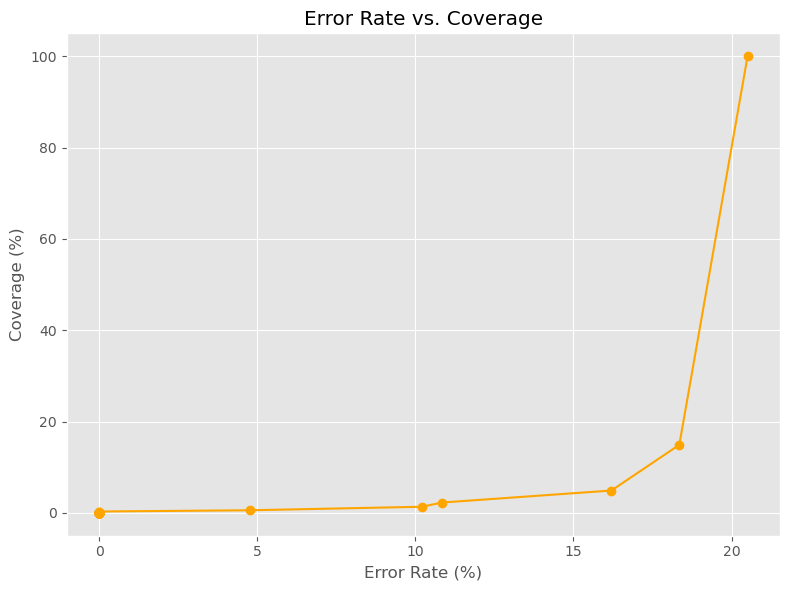

In [41]:
plot(error_rates,coverage_rates)

## Task 4

In [58]:
# your solution
# datasets: first 10 classes of train_dataset and main_test_dataset

In [63]:
# create data loader
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(main_test_dataset, batch_size = 32, shuffle = False)

In [72]:
def filter_first_10_classes(features, labels):
    labels = np.array(labels)
    features = np.stack(features)
    mask = labels < 10
    return features[mask], labels[mask]

In [69]:
train_features, train_labels = extract_features(model, train_loader, device)
test_features, test_labels = extract_features(model, test_loader, device)

Extracting features: 100%|█████████████████████████████████████████████████████████████| 63/63 [00:21<00:00,  2.89it/s]


In [73]:
main_train_features, main_train_labels = filter_first_10_classes(train_features, train_labels)
main_test_features, main_test_labels = filter_first_10_classes(test_features, test_labels)

In [74]:
# Visualize the features

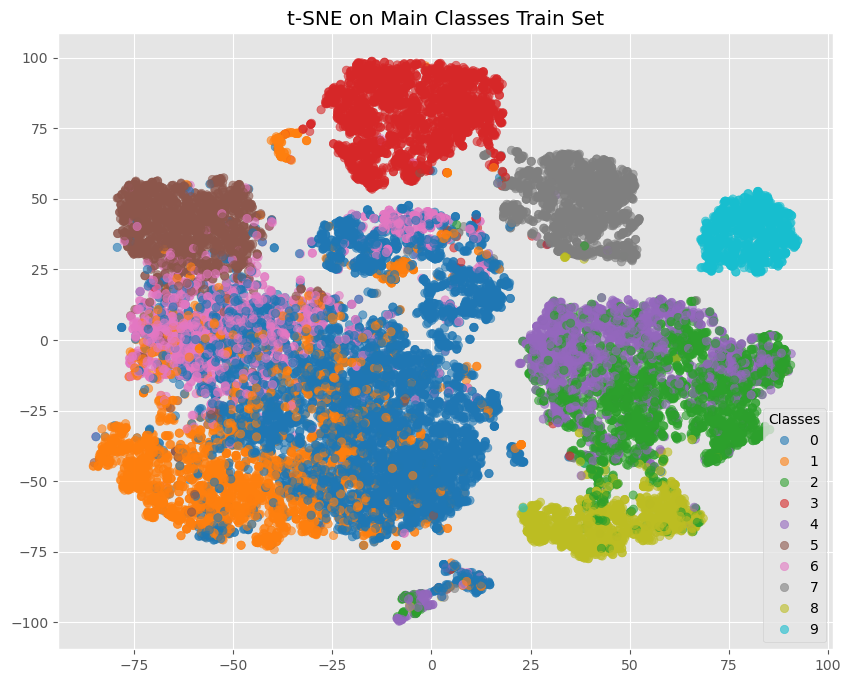

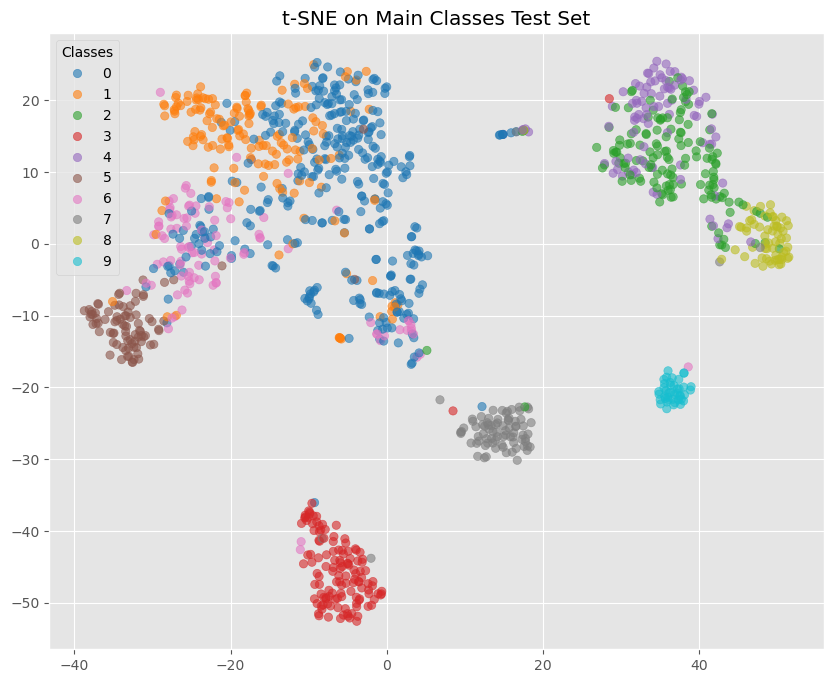

In [75]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def plot_tsne(features, labels, title):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced = tsne.fit_transform(features)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.legend(*scatter.legend_elements(), title="Classes", loc='best')
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_tsne(main_train_features, main_train_labels, "t-SNE on Main Classes Train Set")
plot_tsne(main_test_features, main_test_labels, "t-SNE on Main Classes Test Set")